In [1]:
import os
import glob
import xarray as xr
import netCDF4 as nc
import numpy as np
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import math
import pandas as pd
import dask.array as da
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units

(array([9.44291032e+08, 2.02474200e+06, 2.92389000e+05, 5.98450000e+04,
        1.29370000e+04, 3.11500000e+03, 6.17000000e+02, 8.20000000e+01,
        2.60000000e+01, 1.50000000e+01]),
 array([0.        , 0.00120005, 0.00240011, 0.00360016, 0.00480021,
        0.00600027, 0.00720032, 0.00840038, 0.00960043, 0.01080048,
        0.01200054], dtype=float32),
 <BarContainer object of 10 artists>)

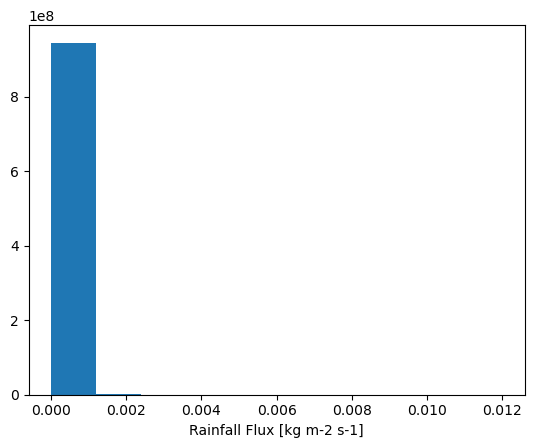

In [30]:
rainf.Rainf.plot()

## Read netcdf files

In [4]:
current_dir = os.getcwd()

# WFDE5 data
wfde5_path = current_dir + '/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/WFDE5/'
psurf_path = glob.glob(wfde5_path + 'psurf/*.nc')
qair_path = glob.glob(wfde5_path + 'qair/*.nc')
rainf_path = glob.glob(wfde5_path + 'rainf/*.nc')
snowf_path = glob.glob(wfde5_path + 'snowf/*.nc')
swdown_path = glob.glob(wfde5_path + 'swdown/*.nc')
tair_path = glob.glob(wfde5_path + 'tair/*.nc')
wind_path = glob.glob(wfde5_path + 'wind/*.nc')
cell_data_path = glob.glob(wfde5_path + 'cell_data/*.nc')
asurf_path = glob.glob(wfde5_path + 'asurf/*.nc')

# Discharge data
discharge_path = glob.glob(current_dir + '/shyft_workspace_copy/shyft_workspace/shyft-data/netcdf/orchestration-testdata/discharge/*.txt')

# Testdata
test_path = current_dir + '/shyft_workspace/shyft-data/netcdf/orchestration-testdata/'
discharge_test_path = test_path + 'discharge.nc'
relhum_test_path = test_path + 'relative_humidity.nc'
precip_test_path = test_path + 'precipitation.nc'
swdown_test_path = test_path + 'radiation.nc'
temp_test_path = test_path + 'temperature.nc'
wind_test_path = test_path + 'wind_speed.nc'
cell_data_test_path = test_path + 'cell_data.nc'

In [5]:
# Datasets from the WDFE5 data
psurf = xr.open_mfdataset(psurf_path)
qair = xr.open_mfdataset(qair_path)
rainf = xr.open_mfdataset(rainf_path)
snowf = xr.open_mfdataset(snowf_path)
swdown = xr.open_mfdataset(swdown_path)
tair = xr.open_mfdataset(tair_path)
wind = xr.open_mfdataset(wind_path)
cell_data = xr.open_mfdataset(cell_data_path)
asurf = xr.open_mfdataset(asurf_path)

# Discharge dataset
discharge = pd.read_csv(discharge_path[0], header= 16)
discharge = discharge.rename(columns = {' 2015 ' : 'daily_flow'})
discharge.index = pd.to_datetime(discharge.index)
discharge_raw_ds = discharge.to_xarray()

# Datsets from nidelva data (on Shyft format)
discharge_test = xr.open_mfdataset(discharge_test_path)
relhum_test = xr.open_mfdataset(relhum_test_path)
precip_test = xr.open_mfdataset(precip_test_path)
swdown_test = xr.open_mfdataset(swdown_test_path)
temp_test = xr.open_mfdataset(temp_test_path)
wind_test = xr.open_mfdataset(wind_test_path)
cell_data_test = xr.open_mfdataset(cell_data_test_path)

In [11]:
rainf.Rainf.values

array([[[          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.9942868e-05, 4.8367230e-05, 4.5257359e-05, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [          nan,           nan,           nan, ...,
         0.000

In [5]:
catchment_id_indices = dict()

for i in range(1,16):
    indx = np.where(cell_data.catchment_id == i)[0]
    catchment_id_indices[f'{i}'] = indx

In [6]:
catchment_id_x_values = dict()

for i in range(1,16):
    catchment_id_x_values[f'{i}'] = cell_data.catchment_id.sel(cell = catchment_id_indices[f'{i}']).x.values

In [7]:
catchment_id_y_values = dict()

for i in range(1,16):
    catchment_id_x_values[f'{i}'] = cell_data.catchment_id.sel(cell = catchment_id_indices[f'{i}']).x.values

## Get variables

In [4]:
# Make dataset where lat, lon have the same dimensions (here such that longitudes match the latitudes)

asurf = asurf.sel(lon = asurf.lon.values[11:58])
#wind = wind.sel(lon = wind.lon.values[11:58])
#psurf = psurf.sel(lon = psurf.lon.values[11:58])
#qair = qair.sel(lon = qair.lon.values[11:58])
rainf = rainf.sel(lon = rainf.lon.values[11:58])
#swdown = swdown.sel(lon = swdown.lon.values[11:58])
tair = tair.sel(lon = tair.lon.values[11:58])

In [5]:
## Update values and do conversions

### Temperature
tair_degC = tair.Tair - 273.15
tair = tair.update({'Tair' : (['time', 'lon', 'lat'], tair_degC.values)})

### Relative humidity using metPy package

#### Convert pressure from Pa to hPa

#psurf_hpa = psurf.PSurf * 0.01

### From rainfall (kg m-2 s-2) to precipitation (mm)

precipitation_mm = rainf.Rainf * 60 * 60


In [6]:
n = int(len(psurf.PSurf) / 6)
tn_1 = tair.isel(time = slice(0, n)).time.values
tn_2 = tair.isel(time = slice(n, 2 * n)).time.values
tn_3 = tair.isel(time = slice(2 * n, 2 * n + n)).time.values
tn_4 = tair.isel(time = slice(3 * n, 3 * n + n)).time.values
tn_5 = tair.isel(time = slice(4 * n, 4 * n + n)).time.values
tn_6 = tair.isel(time = slice(5 * n, 5 * n + n)).time.values


In [7]:
rel_hum_1 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_1).values * units.hPa, tair_degC.sel(time = tn_1).values * units.degC, qair.Qair.sel(time = tn_1).values).to('percent').magnitude

In [8]:
rel_hum_2 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_2).values * units.hPa, tair_degC.sel(time = tn_2).values * units.degC, qair.Qair.sel(time = tn_2).values).to('percent').magnitude

In [9]:
rel_hum_3 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_3).values * units.hPa, tair_degC.sel(time = tn_3).values * units.degC, qair.Qair.sel(time = tn_3).values).to('percent').magnitude

In [10]:
rel_hum_4 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_4).values * units.hPa, tair_degC.sel(time = tn_4).values * units.degC, qair.Qair.sel(time = tn_4).values).to('percent').magnitude

In [11]:
rel_hum_5 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_5).values * units.hPa, tair_degC.sel(time = tn_5).values * units.degC, qair.Qair.sel(time = tn_5).values).to('percent').magnitude

In [12]:
rel_hum_6 = relative_humidity_from_specific_humidity(psurf_hpa.sel(time = tn_6).values * units.hPa, tair_degC.sel(time = tn_6).values * units.degC, qair.Qair.sel(time = tn_6).values).to('percent').magnitude

In [13]:
rel_hum = np.append(rel_hum_1, rel_hum_2).reshape(2 * n, 47, 47)
rel_hum = np.append(rel_hum, rel_hum_3).reshape(3 * n, 47, 47)
rel_hum = np.append(rel_hum, rel_hum_4).reshape(4 * n, 47, 47)
rel_hum = np.append(rel_hum, rel_hum_5).reshape(5 * n, 47, 47)
rel_hum = np.append(rel_hum, rel_hum_6).reshape(6 * n, 47, 47)
rel_hum = rel_hum * 0.01

In [6]:
## Extract lat and lon

lon = asurf.lon.values
lat = asurf.lat.values

In [7]:
## Find UTM CRS
utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=np.min(lon),
        south_lat_degree=np.min(lat),
        east_lon_degree=np.max(lon),
        north_lat_degree=np.max(lat),
    ),
)
utm_45 = CRS.from_epsg('32645')
utm_crs = CRS.from_epsg(utm_crs_list[0].code)
utm_45

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
## Making a pyproj object for UTM Zone 45N

crs_4326 = CRS.from_epsg(4326)
crs_32645 = CRS.from_epsg(32645)

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lon, lat)

In [19]:
# Arughat discharge station coordinates

discharge_stations = {
    0 : {
        'name' : 'Arughat',
        'river' : 'Budhi Gandaki',
        'elevation' : 485,
        'start_date' : '1963-11-28',
        'latitude' : 28.04361,
        'longitude' : 84.81639,
        'x' : 285359.2540269664,
        'y' : 3103956.8282662127,
    }
}

In [20]:
discharge_series = np.array([1])
discharge_series = discharge_series.reshape(1,)
x_discharge = np.array(discharge_stations[0]['x'], dtype = 'float64').reshape((len(discharge_series), ))
y_discharge = np.array(discharge_stations[0]['y'], dtype = 'float64').reshape((len(discharge_series), ))
z_discharge = np.array(discharge_stations[0]['elevation'], dtype = 'float64').reshape((len(discharge_series), ))
x_discharge_da = da.from_array(x_discharge, chunks= len(discharge_series))
y_discharge_da = da.from_array(y_discharge, chunks = len(discharge_series))
z_discharge_da = da.from_array(z_discharge, chunks = len(discharge_series))


In [9]:
asurf_utm = asurf.assign_coords(coords = dict(x = x, y = y))
#wind_utm = wind.assign_coords(coords = dict(x = x, y = y))
#psurf_utm = psurf.assign_coords(coords = dict(x = x, y = y))
#qair_utm = qair.assign_coords(coords = dict(x = x, y = y))
rainf_utm = rainf.assign_coords(coords = dict(x = x, y = y))
#swdown_utm = swdown.assign_coords(coords = dict(x = x, y = y))
tair_utm = tair.assign_coords(coords = dict(x = x, y = y))



#wind_utm = wind_utm.update({'Wind' : (['time', 'x', 'y'], wind_utm.Wind.values)})
#psurf_utm = psurf_utm.update({'PSurf' : (['time', 'x', 'y'], psurf_utm.PSurf.values)})
#rel_hum_utm = qair_utm.update({'relative_humidity' : (['time', 'x', 'y'], rel_hum)})
precipitation_utm = rainf_utm.update({'precipitation' : (['time', 'x', 'y'], precipitation_mm.values )})
#swdown_utm = swdown_utm.update({'SWdown' : (['time', 'x', 'y'], swdown_utm.SWdown.values)})
tair_utm = tair_utm.update({'Tair' : (['time', 'x', 'y'], tair_utm.Tair.values)})


In [52]:
discharge_series = np.array([1])
daily_flow = discharge_raw_ds.daily_flow.values
daily_flow = np.reshape(daily_flow, (len(daily_flow), len(discharge_series)))
daily_flow = da.from_array(daily_flow, chunks = (len(discharge_raw_ds.index), (len(discharge_series))))
series_name = np.array([discharge_stations[0]['name']]).astype('object').reshape(len(discharge_series,))
series_name = da.from_array(series_name, chunks = (len(series_name),) )
discharge_crs = np.array([-2147483647]).astype('int32').reshape(())
catchment_id = np.array([10]).astype('int32').reshape(len(series_name,))
catchment_id = da.from_array(catchment_id)


In [53]:
disc_ds = xr.Dataset(
    data_vars = dict(
        series_name = (['series'], series_name),
        catchment_id = (['series'], catchment_id),
        crs =  discharge_crs,
        discharge = (['time', 'series'], daily_flow),
        
    ),
    coords = dict(
        time = discharge_raw_ds.index.values,
        x = (['series'],x_discharge_da),
        y = (['series'], y_discharge_da),
        z = (['series'], z_discharge_da)
    )
)

In [10]:
#stacked_wind = wind_utm.Wind.stack(station = ['x', 'y'])
#stacked_psurf = psurf_utm.PSurf.stack(station = ['x', 'y'])
#stacked_rel_hum = rel_hum_utm.relative_humidity.stack(station = ['x', 'y'])
stacked_precipitation = precipitation_utm.precipitation.stack(station = ['x', 'y'])
#stacked_swdown = swdown_utm.SWdown.stack(station = ['x', 'y'])
stacked_tair = tair_utm.Tair.stack(station = ['x', 'y'])

#stacked_wind_values = stacked_wind.values
#stacked_psurf_values = stacked_psurf.values
#stacked_rel_hum_values = stacked_rel_hum.values
stacked_precipitation_values = stacked_precipitation.values
#stacked_swdown_values = stacked_swdown.values
stacked_tair_values = stacked_tair.values

In [11]:
#stacked_wind_station = stacked_wind.assign_coords(station = ('station', np.arange(len(stacked_wind.station))))
#stacked_psurf_station = stacked_psurf.assign_coords(station = ('station', np.arange(len(stacked_psurf.station))))
#stacked_rel_hum_station = stacked_rel_hum.assign_coords(station = ('station', np.arange(len(stacked_rel_hum.station))))
stacked_precipitation_station = stacked_precipitation.assign_coords(station = ('station', np.arange(len(stacked_precipitation.station))))
#stacked_swdown_station = stacked_swdown.assign_coords(station = ('station', np.arange(len(stacked_swdown.station))))
stacked_tair_station = stacked_tair.assign_coords(station = ('station', np.arange(len(stacked_tair.station))))


In [12]:
#time_wind = stacked_wind.time.values
time_tair = stacked_tair.time.values
#time_swdown = stacked_swdown.time.values
#time_rel_hum = stacked_rel_hum.time.values
time_precipitation = stacked_precipitation.time.values

#x_wind = stacked_wind.x.values.astype('float64')
#y_wind = stacked_wind.y.values.astype('float64')
x_tair = stacked_tair.x.values.astype('float64')
y_tair = stacked_tair.y.values.astype('float64')
#x_swdown = stacked_swdown.x.values.astype('float64')
#y_swdown = stacked_swdown.y.values.astype('float64')
#x_rel_hum = stacked_rel_hum.x.values.astype('float64')
#y_rel_hum = stacked_rel_hum.y.values.astype('float64')
x_precipitation = stacked_precipitation.x.values.astype('float64')
y_precipitation = stacked_precipitation.y.values.astype('float64')

# Get elevation from each xy-point
z = asurf.ASurf.stack(z_xy = ['lon', 'lat']).values.astype('float64')

#station_wind = stacked_wind_station.station.values.astype('object')
station_tair = stacked_tair_station.station.values.astype('object')
#station_swdown = stacked_swdown_station.station.values.astype('object')
#station_rel_hum = stacked_rel_hum_station.station.values.astype('object')
station_precipitation = stacked_precipitation_station.station.values.astype('object')

#wind_speed = stacked_wind_station.values.astype('float64')
#pressure = stacked_psurf_station.values.astype('float64')
#rel_hum = stacked_rel_hum_station.values.astype('float64')
precipitation = stacked_precipitation_station.values.astype('float64')
#radiation = stacked_swdown_station.values.astype('float64')
temp = stacked_tair_station.values.astype('float64')

crs = np.array(-2147483647).astype('int32')


In [13]:
#x_wind_da = da.from_array(x_wind, chunks= len(x_wind))
#y_wind_da = da.from_array(y_wind, chunks = len(y_wind))
x_tair_da = da.from_array(x_tair, chunks= len(x_tair))
y_tair_da = da.from_array(y_tair, chunks = len(y_tair))
#x_swdown_da = da.from_array(x_swdown, chunks= len(x_swdown))
#y_swdown_da = da.from_array(y_swdown, chunks = len(y_swdown))
#x_rel_hum_da = da.from_array(x_rel_hum, chunks= len(x_rel_hum))
#y_rel_hum_da = da.from_array(y_rel_hum, chunks = len(y_rel_hum))
x_precipitation_da = da.from_array(x_precipitation, chunks= len(x_precipitation))
y_precipitation_da = da.from_array(y_precipitation, chunks = len(y_precipitation))

z_da = da.from_array(z, chunks = len(z))

#series_name_wind_da = da.from_array(station_wind, chunks = len(station_wind))
series_name_tair_da = da.from_array(station_tair, chunks = len(station_tair))
#series_name_swdown_da = da.from_array(station_swdown, chunks = len(station_swdown))
#series_name_rel_hum_da = da.from_array(station_rel_hum, chunks = len(station_rel_hum))
series_name_precipitation_da = da.from_array(station_precipitation, chunks = len(station_precipitation))

#wind_speed_da = da.from_array(wind_speed, chunks = len(wind_speed))
#pressure_da = da.from_array(pressure, chunks = len(pressure))
#rel_hum_da = da.from_array(rel_hum, chunks = len(rel_hum))
precipitation_da = da.from_array(precipitation, chunks = len(precipitation))
#radiation_da = da.from_array(radiation, chunks = len(radiation))
temp_da = da.from_array(temp, chunks = len(temp))


In [14]:
# wind_ds = xr.Dataset(
    
#     data_vars = dict(
#         series_name = (['station'], series_name_wind_da),
#         crs = ([], crs),
#         wind_speed = (['time', 'station'], wind_speed_da)
#     ),
#     coords = dict(
#         time = (['time'], time_wind),
#         x = (['station'], x_wind_da),
#         y = (['station'], y_wind_da),
#         z = (['station'], z_da)
#     ),
   
# )

temp_ds = xr.Dataset(
    
    data_vars = dict(
        series_name = (['station'], series_name_tair_da),
        crs = ([], crs),
        temperature = (['time', 'station'], temp_da)
    ),
    coords = dict(
        time = (['time'], time_tair),
        x = (['station'], x_tair_da),
        y = (['station'], y_tair_da),
        z = (['station'], z_da)
    ),
   
)

# radiation_ds = xr.Dataset(
    
#     data_vars = dict(
#         series_name = (['station'], series_name_swdown_da),
#         crs = ([], crs),
#         global_radiation = (['time', 'station'], radiation_da)
#     ),
#     coords = dict(
#         time = (['time'], time_swdown),
#         x = (['station'], x_swdown_da),
#         y = (['station'], y_swdown_da),
#         z = (['station'], z_da)
#     ), 
# )

# rel_hum_ds = xr.Dataset(
    
#     data_vars = dict(
#         series_name = (['station'], series_name_rel_hum_da),
#         crs = ([], crs),
#         relative_humidity = (['time', 'station'], rel_hum_da)
#     ),
#     coords = dict(
#         time = (['time'], time_rel_hum),
#         x = (['station'], x_rel_hum_da),
#         y = (['station'], y_rel_hum_da),
#         z = (['station'], z_da)
#     ), 
# )

precipitation_ds = xr.Dataset(
    
    data_vars = dict(
        series_name = (['station'], series_name_precipitation_da),
        crs = ([], crs),
        precipitation = (['time', 'station'], precipitation_da)
    ),
    coords = dict(
        time = (['time'], time_precipitation),
        x = (['station'], x_precipitation_da),
        y = (['station'], y_precipitation_da),
        z = (['station'], z_da)
    ), 
)

In [91]:
precipitation_ds

<xarray.Dataset>
Dimensions:        (station: 2209, time: 262968)
Coordinates:
  * time           (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name    (station) object dask.array<chunksize=(2209,), meta=np.ndarray>
    crs            int32 -2147483647
    precipitation  (time, station) float64 dask.array<chunksize=(262968, 2209), meta=np.ndarray>

In [70]:
radiation_ds.global_radiation.values

array([[         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan,          nan, ...,  13.10568905,
         15.96222782,  18.51662064],
       [         nan,          nan,          nan, ..., 132.35348511,
        145.72720337, 154.22503662],
       ...,
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ],
       [         nan,          nan,          nan, ...,   0.        ,
          0.        ,   0.        ]])

In [36]:
temp_ds

<xarray.Dataset>
Dimensions:      (station: 2209, time: 262968)
Coordinates:
  * time         (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name  (station) object dask.array<chunksize=(2209,), meta=np.ndarray>
    crs          int32 -2147483647
    temperature  (time, station) float64 dask.array<chunksize=(262968, 2209), meta=np.ndarray>

In [347]:
wind_ds

<xarray.Dataset>
Dimensions:      (station: 2209, time: 157800)
Coordinates:
  * time         (time) datetime64[ns] 1999-01-01 ... 2016-12-31T23:00:00
    x            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z            (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name  (station) object dask.array<chunksize=(2209,), meta=np.ndarray>
    crs          int32 -2147483647
    wind_speed   (time, station) float64 dask.array<chunksize=(157800, 2209), meta=np.ndarray>

In [114]:
precipitation_ds

<xarray.Dataset>
Dimensions:        (station: 2209, time: 262968)
Coordinates:
  * time           (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z              (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name    (station) object dask.array<chunksize=(2209,), meta=np.ndarray>
    crs            int32 -2147483647
    precipitation  (time, station) float64 dask.array<chunksize=(262968, 2209), meta=np.ndarray>

In [23]:
rel_hum_ds

<xarray.Dataset>
Dimensions:            (station: 2209, time: 262968)
Coordinates:
  * time               (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x                  (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y                  (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z                  (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station
Data variables:
    series_name        (station) object dask.array<chunksize=(2209,), meta=np.ndarray>
    crs                int32 -2147483647
    relative_humidity  (time, station) float64 dask.array<chunksize=(262968, 2209), meta=np.ndarray>

In [39]:
radiation_ds.global_radiation

<xarray.DataArray 'global_radiation' (time: 262968, station: 2209)>
dask.array<array, shape=(262968, 2209), dtype=float64, chunksize=(262968, 2209), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    x        (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    y        (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
    z        (station) float64 dask.array<chunksize=(2209,), meta=np.ndarray>
Dimensions without coordinates: station

In [15]:
# WIND

# wind_ds.x.attrs['axis'] = 'X'
# wind_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
# wind_ds.x.attrs['units'] = 'm'

# wind_ds.y.attrs['axis'] = 'Y'
# wind_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
# wind_ds.y.attrs['units'] = 'm'

# wind_ds.z.attrs['units'] = 'm'
# wind_ds.z.attrs['standard_name'] = 'height'
# wind_ds.z.attrs['axis'] = 'Z'
# wind_ds.z.attrs['long_name'] = 'height above mean sea level'

# wind_ds.series_name.attrs['cf_role'] = 'timeseries_id'

# wind_ds.wind_speed.attrs['units'] = 'm s-1'
# wind_ds.wind_speed.attrs['grid_mapping'] = 'crs'

# wind_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
# wind_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
# wind_ds.crs.attrs['epsg_code'] = 'EPSG:32645'


# TEMPERATURE

temp_ds.x.attrs['axis'] = 'X'
temp_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
temp_ds.x.attrs['units'] = 'm'

temp_ds.y.attrs['axis'] = 'Y'
temp_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
temp_ds.y.attrs['units'] = 'm'

temp_ds.z.attrs['units'] = 'm'
temp_ds.z.attrs['standard_name'] = 'height'
temp_ds.z.attrs['axis'] = 'Z'
temp_ds.z.attrs['long_name'] = 'height above mean sea level'

temp_ds.series_name.attrs['cf_role'] = 'timeseries_id'

temp_ds.temperature.attrs['units'] = 'degC'
temp_ds.temperature.attrs['grid_mapping'] = 'crs'

temp_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
temp_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
temp_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

# RADIATION

# radiation_ds.x.attrs['axis'] = 'X'
# radiation_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
# radiation_ds.x.attrs['units'] = 'm'

# radiation_ds.y.attrs['axis'] = 'Y'
# radiation_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
# radiation_ds.y.attrs['units'] = 'm'

# radiation_ds.z.attrs['units'] = 'm'
# radiation_ds.z.attrs['standard_name'] = 'height'
# radiation_ds.z.attrs['axis'] = 'Z'
# radiation_ds.z.attrs['long_name'] = 'height above mean sea level'

# radiation_ds.series_name.attrs['cf_role'] = 'timeseries_id'

# radiation_ds.global_radiation.attrs['units'] = 'W m-2'
# radiation_ds.global_radiation.attrs['grid_mapping'] = 'crs'

# radiation_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
# radiation_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
# radiation_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

# RELATIVE HUMIDITY

# rel_hum_ds.x.attrs['axis'] = 'X'
# rel_hum_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
# rel_hum_ds.x.attrs['units'] = 'm'

# rel_hum_ds.y.attrs['axis'] = 'Y'
# rel_hum_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
# rel_hum_ds.y.attrs['units'] = 'm'

# rel_hum_ds.z.attrs['units'] = 'm'
# rel_hum_ds.z.attrs['standard_name'] = 'height'
# rel_hum_ds.z.attrs['axis'] = 'Z'
# rel_hum_ds.z.attrs['long_name'] = 'height above mean sea level'

# rel_hum_ds.series_name.attrs['cf_role'] = 'timeseries_id'

# rel_hum_ds.relative_humidity.attrs['units'] = '-'
# rel_hum_ds.relative_humidity.attrs['grid_mapping'] = 'crs'

# rel_hum_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
# rel_hum_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
# rel_hum_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

# PRECIPITATION

precipitation_ds.x.attrs['axis'] = 'X'
precipitation_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
precipitation_ds.x.attrs['units'] = 'm'

precipitation_ds.y.attrs['axis'] = 'Y'
precipitation_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
precipitation_ds.y.attrs['units'] = 'm'

precipitation_ds.z.attrs['units'] = 'm'
precipitation_ds.z.attrs['standard_name'] = 'height'
precipitation_ds.z.attrs['axis'] = 'Z'
precipitation_ds.z.attrs['long_name'] = 'height above mean sea level'

precipitation_ds.series_name.attrs['cf_role'] = 'timeseries_id'

precipitation_ds.precipitation.attrs['units'] = 'mm h-1'
precipitation_ds.precipitation.attrs['grid_mapping'] = 'crs'

precipitation_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
precipitation_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
precipitation_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

# DISCHARGE

# disc_ds.x.attrs['axis'] = 'X'
# disc_ds.x.attrs['standard_name'] = 'projection_x_coordinate'
# disc_ds.x.attrs['units'] = 'm'

# disc_ds.y.attrs['axis'] = 'Y'
# disc_ds.y.attrs['standard_name'] = 'projection_y_coordinate'
# disc_ds.y.attrs['units'] = 'm'

# disc_ds.z.attrs['units'] = 'm'
# disc_ds.z.attrs['standard_name'] = 'height'
# disc_ds.z.attrs['axis'] = 'Z'
# disc_ds.z.attrs['long_name'] = 'height above mean sea level'

# disc_ds.series_name.attrs['cf_role'] = 'timeseries_id'

# disc_ds.discharge.attrs['units'] = 'm3 s-1'
# disc_ds.discharge.attrs['grid_mapping'] = 'crs'

# disc_ds.crs.attrs['proj'] = '+proj=utm +zone=45 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
# disc_ds.crs.attrs['grid_mapping_name'] = 'transverse_mercator'
# disc_ds.crs.attrs['epsg_code'] = 'EPSG:32645'

In [46]:
discharge_test

<xarray.Dataset>
Dimensions:       (time: 1096, series: 6)
Coordinates:
  * time          (time) datetime64[ns] 2012-12-31T23:00:00 ... 2015-12-31T23...
    x             (series) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    y             (series) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    z             (series) float64 dask.array<chunksize=(6,), meta=np.ndarray>
Dimensions without coordinates: series
Data variables:
    series_name   (series) object dask.array<chunksize=(6,), meta=np.ndarray>
    catchment_id  (series) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    crs           int32 ...
    discharge     (time, series) float64 dask.array<chunksize=(1096, 6), meta=np.ndarray>

In [16]:
## Specify path where files are saved
home_dir = os.getenv('HOME')
output_folder = home_dir + '/Downloads'
output_wind = output_folder + '/wind_speed.nc'
output_rel_hum = output_folder + '/relative_humidity.nc'
output_temp = output_folder + '/temperature.nc'
output_radiation = output_folder + '/radiation.nc'
output_precipitation = output_folder + '/precipitation.nc'
output_discharge = output_folder + '/discharge.nc'


In [22]:
temp_ds.temperature.values.max()

nan

In [29]:
## Save netcdf files
#wind_ds.to_netcdf(path = output_wind, format = 'NETCDF4')
#rel_hum_ds.to_netcdf(path = output_rel_hum, format = 'NETCDF4')
temp_ds.to_netcdf(path = output_temp, format = 'NETCDF4')
#radiation_ds.to_netcdf(path = output_radiation, format = 'NETCDF4')
#precipitation_ds.to_netcdf(path = output_precipitation, format = 'NETCDF4')
#disc_ds.to_netcdf(path = output_discharge, format = 'NETCDF4')

/Users/jacobqs/opt/miniconda3/envs/geohyd/lib/python3.10/site-packages/xarray/conventions.py:205: SerializationWarning: variable series_name has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


In [116]:
o = xr.open_mfdataset(output_rel_hum)
o.relative_humidity.values.min()

0.0